In [37]:
# def crop_barcode(img: Image) -> Image:
#     if len(img.shape) == 3:
#         img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

#     # Thresholding and morphological operations
#     _, thresholded = cv.threshold(img, 180, 255, cv.THRESH_BINARY_INV)
#     kernel = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
#     thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, kernel)

#     # Find contours and filter by area and aspect ratio
#     contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#     # Find the largest contour assuming it represents the barcode
    
#     largest_contour = max(contours, key=cv.contourArea)
    
#     # Get rotated bounding box
#     rect = cv.minAreaRect(largest_contour)
#     box = cv.boxPoints(rect)
#     box = np.intp(box)

#     # Ensure width is always greater than height
#     width = int(max(rect[1]))
#     height = int(min(rect[1]))

#     # Define the source and destination points for perspective transformation
#     src_pts = box.astype("float32")
#     dst_pts = np.array(
#         [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]],
#         dtype="float32",
#     )

#     # Compute the perspective transform matrix
#     M = cv.getPerspectiveTransform(src_pts, dst_pts)

#     # Warp the image to get a straightened barcode
#     cropped = cv.warpPerspective(img, M, (width, height))
    
  

#     return cropped

In [38]:
import os
from typing import Optional
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
Image = np.ndarray

import cv2 as cv
import numpy as np
from typing import Tuple

In [39]:
def crop_barcode(img: np.ndarray) -> np.ndarray:
    # Step 1: Convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Step 2: Thresholding
    _, thresholded = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
    
    # Step 3: Morphological Closing
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
    thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, kernel)
    
    # Step 4: Find contours
    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours detected. Unable to locate barcode.")
    
    # Step 5: Find the largest contour (assumed to be the barcode)
    largest_contour = max(contours, key=cv.contourArea)
    
    # Step 6: Use minAreaRect to find orientation and bounding box
    rect = cv.minAreaRect(largest_contour)
    angle = rect[-1]

    # Adjust the angle to the correct range for deskewing
    if angle < -45:
        angle += 90

    # Debug: Print the detected angle
    print(f"Detected rotation angle: {angle} degrees")

    # Rotate the image to deskew the barcode only if necessary
    if abs(angle - 90) > 1 and abs(angle) > 1:  # Check if rotation is necessary
        (h, w) = img.shape
        center = (w // 2, h // 2)
        rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv.warpAffine(img, rotation_matrix, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
        thresholded_rotated = cv.warpAffine(thresholded, rotation_matrix, (w, h))  # Rotate thresholded image
    else:
        rotated_img = img  # No rotation needed
        thresholded_rotated = thresholded  # Use original thresholded image

    # Step 8: Extract the barcode region after rotation
    contours, _ = cv.findContours(thresholded_rotated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv.contourArea)
    rect = cv.minAreaRect(largest_contour)
    box = cv.boxPoints(rect)
    box = np.int0(box)
    
    # Create a bounding box to crop the barcode
    x_min, x_max = min(box[:, 0]), max(box[:, 0])
    y_min, y_max = min(box[:, 1]), max(box[:, 1])
    cropped_img = rotated_img[y_min:y_max, x_min:x_max]
    
    return cropped_img


Detected rotation angle: -0.0 degrees


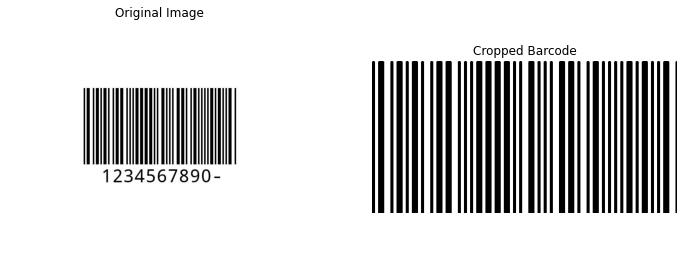

Detected rotation angle: -0.0 degrees


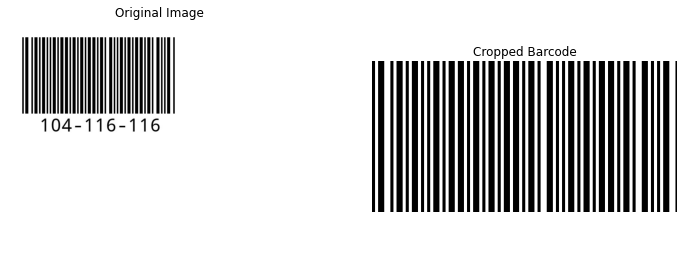

Image contains colors
Detected rotation angle: -0.0 degrees


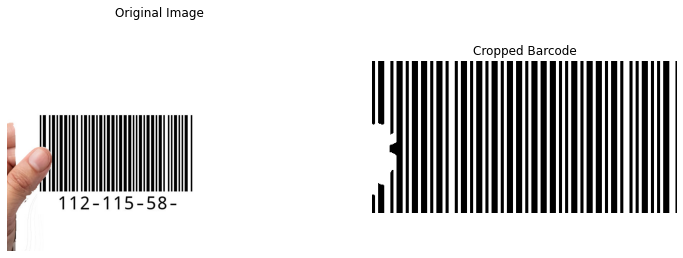

Detected rotation angle: 90.0 degrees


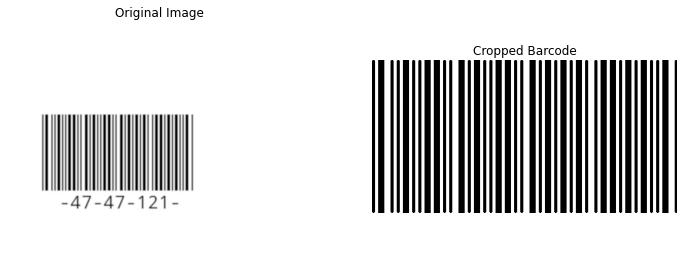

Detected rotation angle: 90.0 degrees


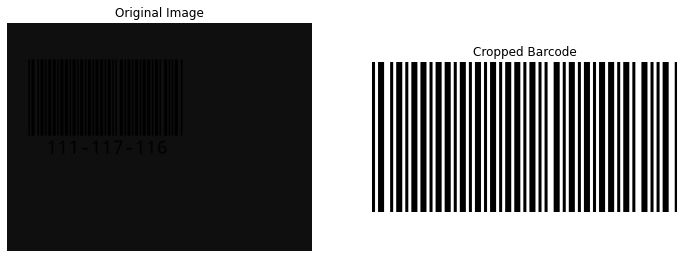

Detected rotation angle: 90.0 degrees


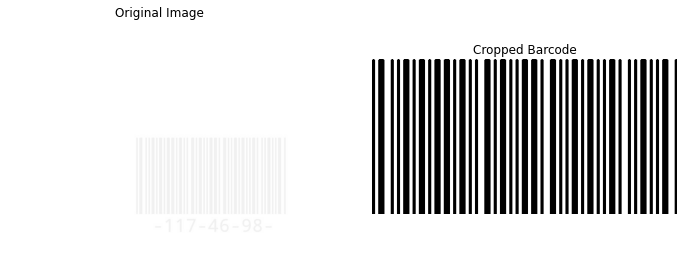

Detected rotation angle: 90.0 degrees


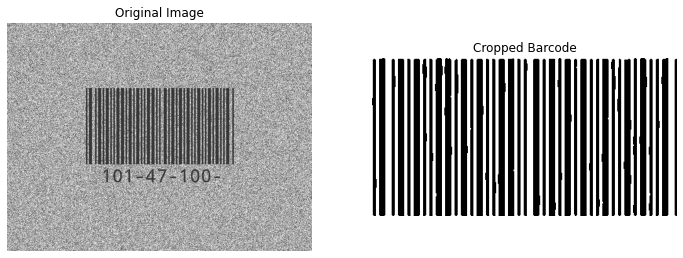

Detected rotation angle: 90.0 degrees


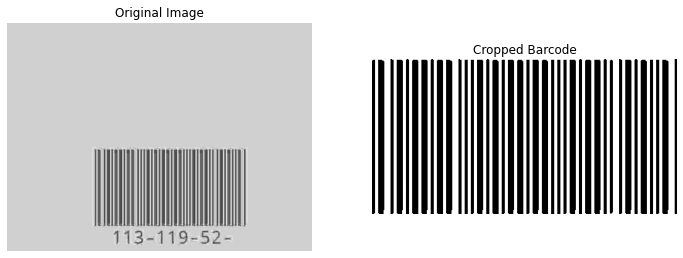

Detected rotation angle: 62.03288269042969 degrees


error: OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [40]:

def preprocess_image(image: Image) -> Image:
    img = image.copy()

    if len(img.shape) == 3:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        img_gray = img
    
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Step 2: Detect if the image contains colors
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])
    lower_gray = np.array([0, 0, 50])
    upper_gray = np.array([180, 50, 200])
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])

    # Create masks for black, gray, and white
    black_mask = cv.inRange(img_hsv, lower_black, upper_black)
    gray_mask = cv.inRange(img_hsv, lower_gray, upper_gray)
    white_mask = cv.inRange(img_hsv, lower_white, upper_white)

    # Combine the masks
    combined_mask = cv.bitwise_or(black_mask, gray_mask)
    combined_mask = cv.bitwise_or(combined_mask, white_mask)

    # Invert the mask to get non-gray colors
    non_gray_mask = cv.bitwise_not(combined_mask)

    # Step 3: Check if there are non-gray pixels and inpaint if colors are detected
    if non_gray_mask.any():
        print("Image contains colors")
        lower_color = np.array([0, 30, 60])
        upper_color = np.array([20, 150, 255])
        mask = cv.inRange(img_hsv, lower_color, upper_color)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
        mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
        inpainted_image = cv.inpaint(img, mask, inpaintRadius=3, flags=cv.INPAINT_TELEA)
        img_gray = cv.cvtColor(inpainted_image, cv.COLOR_BGR2GRAY)
        _, img_gray = cv.threshold(img_gray, 50, 255, cv.THRESH_BINARY)
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 7))  
        kernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 1000))
        
          
    img_blurred = cv.medianBlur(cv.blur(img_gray, (3, 3)), 3)
    _, img_denoised = cv.threshold(img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    closing_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 5))
    img_denoised = cv.morphologyEx(img_denoised, cv.MORPH_CLOSE, closing_kernel, iterations=2)
    
    
    # Check for sine wave noise
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (50, 1))
    img_dilated = cv.morphologyEx(img_denoised, cv.MORPH_DILATE, kernel)
    if len(np.unique(img_dilated)) > 1:
        print("Image contains sine wave noise")
        img_denoised = cv.adaptiveThreshold(
            img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2
        )    
    return img_denoised


def remove_hand(img: Image) -> Optional[Image]:
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
    upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)
    lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
    upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)

    mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
    mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
    skin_mask = cv.bitwise_or(mask1, mask2)

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_CLOSE, kernel, iterations=2)
    skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_OPEN, kernel, iterations=2)

    contours, _ = cv.findContours(skin_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  

    largest_contour = max(contours, key=cv.contourArea)

    hand_mask = np.zeros_like(skin_mask)
    cv.drawContours(hand_mask, [largest_contour], -1, 255, thickness=cv.FILLED)

    hand_mask_inv = cv.bitwise_not(hand_mask)

    img_no_hand = cv.inpaint(img, hand_mask, inpaintRadius=3, flags=cv.INPAINT_TELEA)

    gray = cv.cvtColor(img_no_hand, cv.COLOR_BGR2GRAY)

    erosion_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 50))
    binary_erode = cv.erode(gray, erosion_kernel, iterations=2)

    dilation_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 60))
    binary_opened = cv.dilate(binary_erode, dilation_kernel, iterations=3)

    dilationkernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 10))
    binary_final = cv.dilate(binary_opened, dilationkernel2, iterations=2)

    kernel = np.ones((30, 1), np.float32) / 30
    vertical_mean_filtered = cv.filter2D(binary_final, -1, kernel)

    img = cv.normalize(vertical_mean_filtered, None, 0, 255, cv.NORM_MINMAX)

    return img


def vertical_erosion_dilation(image):
    """
    Perform vertical erosion and then vertical dilation on an input image.

    Args:
        image (numpy.ndarray): The input image (Mat-like object) as a NumPy array.

    Returns:
        numpy.ndarray: The image after vertical erosion and dilation.
    """
    if image is None:
        raise ValueError("Input image cannot be None")

    # Create a vertical kernel
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 50))  
    kernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 10))  
    kernel3 = cv.getStructuringElement(cv.MORPH_RECT, (1, 60))  
    


    # Perform vertical erosion
    eroded = cv.erode(image, kernel, iterations=2)

    # Perform vertical dilation
    dilated = cv.dilate(eroded, kernel3, iterations=3)

    dilated2 = cv.dilate(dilated, kernel2, iterations=2)

    return dilated2


    
    
def display_before_after(original_img: Image, cropped_img: Image, title_before: str = "Original Image", title_after: str = "Cropped Barcode"):
    plt.figure(figsize=(12, 6))
    images = [(original_img, title_before), (cropped_img, title_after)]
    for i, (img, title) in enumerate(images):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img if len(img.shape) == 2 else cv.cvtColor(img, cv.COLOR_BGR2RGB), cmap='gray' if len(img.shape) == 2 else None)
        plt.title(title)
        plt.axis("off")
    plt.show()

def process_test_cases(image_folder: str):
    files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    files.sort(key=lambda x: int(os.path.splitext(x)[0].split()[0]))
    output_folder = os.path.join(image_folder, "Processed_Output")
    os.makedirs(output_folder, exist_ok=True)

    for i, file_name in enumerate(files):
        image_path = os.path.join(image_folder, file_name)
        original_img = cv.imread(image_path)
        if original_img is None:
            print(f"Could not read image {file_name}. Skipping...")
            continue

        cleaned_img = preprocess_image(original_img)
        cropped_img = crop_barcode(cleaned_img)
        # cropped_img =  vertical_erosion_dilation(cropped_img)
        cv.imwrite(os.path.join(output_folder, f"Cropped_{file_name}"), cropped_img)
        display_before_after(original_img, cropped_img)

if __name__ == "__main__":
    folder = "/Users/mohamedwalid/Desktop/Semester 7/Computer vision/CV-main/Test Cases-20241123"
    process_test_cases(folder)

In [36]:
import os
from typing import Optional
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def decoder(your_cropped_image):
    """
    Decodes a Code 11 barcode from a cropped image.
    
    Args:
        your_cropped_image (numpy.ndarray): The cropped barcode image in grayscale.
        
    Returns:
        list: Decoded digits as a list of strings, excluding 'Stop/Start'.
    """
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = your_cropped_image.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    return digits

cropped_image_path_Folder = '/Users/mohamedwalid/Desktop/Semester 7/Computer vision/CV-main/Test Cases-20241123/Processed_Output'

# Get a sorted list of image files
cropped_images = sorted(os.listdir(cropped_image_path_Folder))

for cropped_image in cropped_images:
    cropped_image_path = os.path.join(cropped_image_path_Folder, cropped_image)
    cropped_img = cv.imread(cropped_image_path, cv.IMREAD_GRAYSCALE)
    if cropped_img is not None:
        decoded_digits = decoder(cropped_img)
        print("Decoded barcode:", ''.join(decoded_digits))
    else:
        print("Failed to load the cropped image:", cropped_image_path)

Failed to load the cropped image: /Users/mohamedwalid/Desktop/Semester 7/Computer vision/CV-main/Test Cases-20241123/Processed_Output/.DS_Store
Decoded barcode: Stop/Start1234567890-
Decoded barcode: Stop/Start104-116-116
Decoded barcode: Stop/Start112-115-58-
Decoded barcode: Stop/Start-47-47-121-
Decoded barcode: Stop/Start111-117-116
Decoded barcode: Stop/Start-117-46-98-
Decoded barcode: 
Decoded barcode: Stop/Start113-119-52-
Decoded barcode: 
Decoded barcode: Stop/Start103-120-99-
Decoded barcode: 
